In [13]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.ndimage import convolve
from scipy import signal
import h5py
import glob
import itertools
from ast import literal_eval
from scipy.interpolate import interp1d
sys.path.append('../src')
from settings import FilterSettings

result_settings = FilterSettings()



def roc_params_build(rocx, rocy, ftype):
    output = {}
    bound_sup = result_settings.sup
    bound_inf = result_settings.inf
    basis = np.linspace(bound_inf, bound_sup, result_settings.roc_grid)
    for i in range(0, rocx.shape[1]):
        xt = interp1d(rocx[:,i], basis, fill_value = 'extrapolate')
        yt = interp1d(rocy[:,i],basis, fill_value = 'extrapolate')
        tx = interp1d(basis,rocx[:,i], fill_value = 'extrapolate')
        ty = interp1d(basis,rocy[:,i], fill_value = 'extrapolate')
        xy = interp1d(rocx[:,i], rocy[:,i], fill_value = 'extrapolate')
        yx = interp1d(rocy[:,i], rocx[:,i], fill_value = 'extrapolate')
        output[ftype[i]] = [[xt,tx],[yt,ty],[xy,yx]]
   
    return output

def bug_array_fix(df, column):
    df_out = df[column]
    df_out = df_out.str.replace('\n',',').str.replace('  ',',').str.replace('[','').str.replace(']','').str.replace(' ',',').str.split(',')
    return df_out.apply(lambda x: (np.array(x)[np.array(x)!='']).astype(np.float))

def get_roc_params(dfx,dfy, sg_eff = 0.99):
    roc_x = np.array(np.matrix(dfx.tolist()))
    roc_y = np.array(np.matrix(dfy.tolist()))
    auc = abs(np.diff(np.array(roc_x))*np.array(roc_y)[:,:-1]).sum(axis = 1)
    bg_fix = []
    for i in range(0,roc_x.shape[0]):
        x = np.array(roc_x[i,:])
        y = np.array(roc_y[i,:])
        f = interp1d(x,y,fill_value = 'extrapolate')
        bg_fix.append(f(sg_eff))
    return auc, bg_fix, roc_y[:,index]


def roc_params(dfx, dfy, thresholds):
  bound_sup = result_settings.sup
  bound_inf = result_settings.inf
  basis = np.linspace(bound_inf, bound_sup, result_settings.roc_grid)
  roc_x = np.array(np.matrix(dfx.tolist()))
  roc_y = np.array(np.matrix(dfy.tolist()))
  auc = abs(np.diff(np.array(roc_x))*np.array(roc_y)[:,:-1]).sum(axis = 1)
  signal_eff = np.zeros((roc_x.shape[0], len(thresholds)))
  bg_eff = np.zeros((roc_x.shape[0], len(thresholds)))
  roc_point = np.zeros((roc_x.shape[0], len(thresholds)))
  for (n, t) in list(enumerate(thresholds)):
    for i in range(0,roc_x.shape[0]):
      x = np.array(roc_x[i,:])
      y = np.array(roc_y[i,:])
      fx = interp1d(basis, x, fill_value = 'extrapolate')
      fy = interp1d(basis, y, fill_value = 'extrapolate')
      fxy = interp1d(x, y, fill_value = 'extrapolate')
      signal_eff[i, n] = fx(t)
      bg_eff[i, n] = fy(t)
      roc_point[i, n] = fxy(t)
   
  return auc, signal_eff, bg_eff, roc_point 



def scatter(df_filt, key_analysis, labels, title):
    import matplotlib
    #key_analysis = ['Intensity mean','delta_bg_eff_1_cumulative']
    fig = plt.figure(figsize=(12,8))
    x           = df_filt[key_analysis[0]]
    y           = df_filt[key_analysis[1]]
    label_name  = df_filt.ftype

    ## enconding labels
    from sklearn import preprocessing
    le          = preprocessing.LabelEncoder()
    le.fit(label_name)
    label       = le.transform(label_name)

    ## selecionando cores para plot de forma randomica
    np.random.seed(10)
    colors = np.random.rand(len(np.unique(label)),3)

    ## scatter plots pelas cores de cada classe (w)
    plt.scatter(x, 100*y, c=label, alpha=0.3,cmap=matplotlib.colors.ListedColormap(colors))

    ## ajustes do plot e barra de exibicao
    plt.xlabel(labels[0],fontsize = 14)
    plt.ylabel(labels[1],fontsize = 12)
    plt.title(title)
    plt.grid()
    cb = plt.colorbar()
    loc = np.arange(0,max(label),max(label)/float(len(colors)))
    cb.set_ticks(loc+0.25)
    ## criando labels na colorbar
    ticklabels = []
    for i in np.unique(label_name):
        ticklabels.append(i)

    cb.set_ticklabels(ticklabels)

In [14]:
file_dir = result_settings.output_file_path + result_settings.output_file_name+'.csv'
df = pd.read_csv(file_dir)
df.head()

,SNR,w_size,Energy,Area,filter,window,ROCx,ROCy,Energy Estimated
0,-34.960012,1.0,2539.0,561.0,unsupervised_wiener,1.0,[1. 1. 1. 1. 1...,[0.00000000e+00 0.00000000e+00 0.00000000e+00 ...,[2000.17303219 2000.17303219 2000.17303219 200...
1,-42.575234,1.0,1683.0,677.0,unsupervised_wiener,1.0,[1. 1. 1. 1. 1...,[0.00000000e+00 0.00000000e+00 0.00000000e+00 ...,[1398.53526512 1398.53526512 1398.53526512 139...
2,-31.146305,1.0,4110.0,925.0,unsupervised_wiener,1.0,[1. 1. 1. 1. 1...,[0.00000000e+00 0.00000000e+00 0.00000000e+00 ...,[2606.18313574 2606.18313574 2606.18313574 260...
3,-40.762318,1.0,2123.0,703.0,unsupervised_wiener,1.0,[1. 1. 1. 1. 1...,[0.00000000e+00 0.00000000e+00 0.00000000e+00 ...,[1696.5881745 1696.5881745 1696.5881745 169...
4,-30.095966,1.0,4106.0,942.0,unsupervised_wiener,1.0,[1. 1. 1. 1. 1...,[0.00000000e+00 0.00000000e+00 0.00000000e+00 ...,[3137.43109948 3137.43109948 3137.43109948 313...


In [15]:
df_old = pd.read_csv('../data/result_test.csv')
df_old.head()

,SNR,w_size,Energy,Area,filter,window,ROCx,ROCy,Energy Estimated
0,-98.861418,1.0,2539.0,561.0,mean,1.0,[0.99821747 0.99821747 0.99821747 0.99821747 0...,[0.00286334 0.00299714 0.00313476 0.0033412 0...,[2153.5234971 2153.5234971 2153.5234971 215...
1,-100.453531,1.0,1683.0,677.0,mean,1.0,[0.9985229 0.9985229 0.9985229 0.9985229 0...,[0.00282254 0.00298317 0.00313233 0.00330826 0...,[1537.86007041 1537.86007041 1537.86007041 153...
2,-88.543275,1.0,4110.0,925.0,mean,1.0,[0.99675676 0.99567568 0.99567568 0.99567568 0...,[0.00285201 0.0030128 0.00321186 0.00337648 0...,[3244.60270383 3273.59859894 3273.59859894 327...
3,-103.678260,1.0,2123.0,703.0,mean,1.0,[1. 0.99857752 0.99857752 0.99857752 0...,[0.00286107 0.00299876 0.00317089 0.00337361 0...,[1736.39509241 1743.98105878 1743.98105878 174...
4,-81.402118,1.0,4106.0,942.0,mean,1.0,[0.99787686 0.99787686 0.99787686 0.99787686 0...,[0.00287134 0.00299768 0.00315848 0.00334224 0...,[3623.71714488 3623.71714488 3623.71714488 362...


In [16]:
df['ROCx'] = bug_array_fix(df,'ROCx')
df['ROCy'] = bug_array_fix(df,'ROCy')

In [17]:
t_values    = [.5,1.,1.5]
new_sg_columns = ['sg_eff_'+str(i) for i in t_values]
new_bg_columns = ['bg_eff_'+str(i) for i in t_values] 
auc,sg,bg,_ = roc_params(df['ROCx'], df['ROCy'],[1,1.5,2])
efficiency_df = pd.DataFrame(np.append(sg,bg,axis = 1), columns=new_sg_columns+new_bg_columns)
df = pd.concat([df,efficiency_df],axis = 1)

/home/guilherme/anaconda3/lib/python3.7/site-packages/scipy/interpolate/interpolate.py:609: RuntimeWarning: invalid value encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/guilherme/anaconda3/lib/python3.7/site-packages/scipy/interpolate/interpolate.py:609: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


In [18]:
index = list(range(0,100))
n_size = df.shape[0]//100
indexes = n_size*index
df['image_num'] = indexes
df.head(3)

,SNR,w_size,Energy,Area,filter,window,ROCx,ROCy,Energy Estimated,sg_eff_0.5,sg_eff_1.0,sg_eff_1.5,bg_eff_0.5,bg_eff_1.0,bg_eff_1.5,image_num
0,-34.960012,1.0,2539.0,561.0,unsupervised_wiener,1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",[2000.17303219 2000.17303219 2000.17303219 200...,0.611408,0.419340,0.261438,0.981952,0.998569,0.999912,0
1,-42.575234,1.0,1683.0,677.0,unsupervised_wiener,1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",[1398.53526512 1398.53526512 1398.53526512 139...,0.305761,0.165436,0.088626,0.981013,0.998384,0.999850,1
2,-31.146305,1.0,4110.0,925.0,unsupervised_wiener,1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",[2606.18313574 2606.18313574 2606.18313574 260...,0.454595,0.280450,0.177658,0.981068,0.998477,0.999840,2


In [19]:
deltas = ['delta_' + st for st in list(efficiency_df.columns) + ['SNR']]
cumulatives = [i + '_cumulative' for i in deltas]
columns = list(df.columns) + deltas + cumulatives
dfObj = pd.DataFrame(columns=columns)
dfObj

,SNR,w_size,Energy,Area,filter,window,ROCx,ROCy,Energy Estimated,sg_eff_0.5,...,delta_bg_eff_1.0,delta_bg_eff_1.5,delta_SNR,delta_sg_eff_0.5_cumulative,delta_sg_eff_1.0_cumulative,delta_sg_eff_1.5_cumulative,delta_bg_eff_0.5_cumulative,delta_bg_eff_1.0_cumulative,delta_bg_eff_1.5_cumulative,delta_SNR_cumulative


In [21]:
values = list(df.groupby(by=['image_num','filter']))
data = pd.DataFrame([],columns = values[0][1].columns)

In [22]:
for i in range(0,len(values)):
    aux = values[i][1]
    for key1,key2 in zip(deltas, cumulatives):
        diff = np.pad(np.diff(aux[key1.split('delta_')[1]]),(1,0),'constant')
        diff_cum = diff.cumsum()
        aux[key1] = diff
        aux[key2] = diff_cum
        #data.columns = aux.columns
    data = data.append(aux)      

/home/guilherme/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


In [23]:
df = data
df['Intensity mean'] = df['Energy']/df['Area']

In [24]:
## filtrando dados para visualizacao
filtro = ['unsupervised_wiener']   ## somente filtros listados
window = [1,3,5,7]              ## somente nestas janelas

df_filt    = df[df.window.isin(window)]
pattern    = '|'.join(filtro)
df_filt    = df_filt[df_filt['filter'].str.contains(pattern)]
new_column = df_filt['filter']  + ', window = ' + df_filt['window'].astype('str') 
df_filt.drop(['filter','window'],axis = 1,inplace = True)
df_filt['ftype']  = new_column
df_filt.head(3)

,Area,Energy,Energy Estimated,ROCx,ROCy,SNR,bg_eff_0.5,bg_eff_1.0,bg_eff_1.5,delta_SNR,...,delta_sg_eff_1.0_cumulative,delta_sg_eff_1.5,delta_sg_eff_1.5_cumulative,image_num,sg_eff_0.5,sg_eff_1.0,sg_eff_1.5,w_size,Intensity mean,ftype
0,561.0,2539.0,[2000.17303219 2000.17303219 2000.17303219 200...,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",-34.960012,0.981952,0.998569,0.999912,0.000000,...,0.000000,0.000000,0.000000,0,0.611408,0.419340,0.261438,1.0,4.525847,"unsupervised_wiener, window = 1.0"
100,561.0,2539.0,[2000.17303219 2000.17303219 2000.17303219 200...,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",-37.911650,0.939650,0.987213,0.997339,-2.951639,...,0.058675,0.071301,0.071301,0,0.637255,0.478015,0.332739,3.0,4.525847,"unsupervised_wiener, window = 3.0"
200,561.0,2539.0,[2000.17303219 2000.17303219 2000.17303219 200...,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",-41.194914,0.859756,0.940027,0.975701,-3.283264,...,0.134878,0.113488,0.184789,0,0.672906,0.554219,0.446227,5.0,4.525847,"unsupervised_wiener, window = 5.0"


## Rejeição de background 1.5 sigma

## Construindo a ROC média e std

In [25]:
#df_filt
filters = df_filt['ftype'].unique()
mean_sg = np.zeros((df_filt['ROCx'].iloc[0].shape[0],
                    filters.shape[0]))
std_sg = np.zeros_like(mean_sg)
mean_bg = np.zeros_like(mean_sg)
std_bg = np.zeros_like(mean_sg)
for i,f in list(enumerate(filters)):
    aux = df_filt[df_filt['ftype'] == f]
    roc_x = np.array(aux['ROCx'].tolist())
    roc_y = np.array(aux['ROCy'].tolist())
    if(len(roc_x.shape) > 2):
        roc_x = roc_x[:,:,0]
    mean_sg[:,i] = roc_x.mean(axis=0)
    std_sg[:,i] = roc_x.std(axis = 0)
    mean_bg[:,i] = roc_y.mean(axis=0)
    std_bg[:,i] = roc_y.std(axis=0)

## Plot das ROC's para sinal fixo -> melhoria no numero de pixels de background (tempo de processamento)

In [26]:
mean_bg.shape

(120, 4)

Text(0, 0.5, 'Background rejection efficiency')

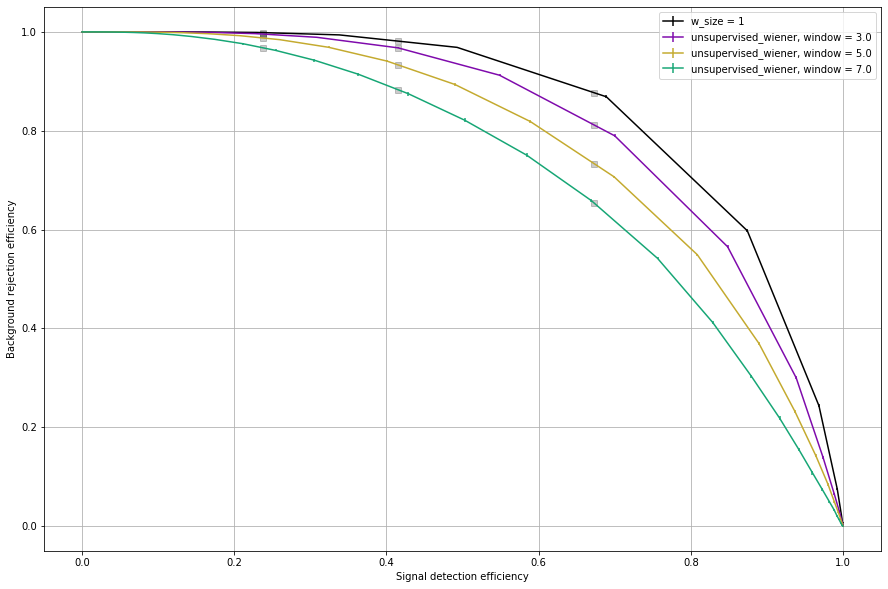

In [28]:
np.random.seed(0)
thr_points = [0.5,1,1.5]
new_thr_values = []
objects = roc_params_build(mean_sg,mean_bg,filters)
base_signal_values = objects[filters[0]][0][1](thr_points)
base_background_values = []
fig,ax = plt.subplots(1,1, figsize=(15,10))
flag = 0
for i,f in list(enumerate(filters)):
    base_background_values.append(objects[f][2][0](base_signal_values))
    if (sum(df_filt[df_filt['w_size'] == 1.0]['ftype'] == filters[i]) != 0):
        color = 'black'
        label = 'w_size = 1'
        flag+=1
        if flag<=1:
            ax.errorbar(mean_sg[:,i],
                        mean_bg[:,i],
                        2*std_bg[:,i],
                        linestyle = '-',
                        label = label,
                        color = color) 
            
    else:
        color = '#%06X' % np.random.randint(0, 0xFFFFFE)
        label = f
        ax.errorbar(mean_sg[:,i],
                    mean_bg[:,i],
                    2*std_bg[:,i],
                    linestyle = '-',
                    label = label,
                    color = color) 
base_background_values = np.array(base_background_values).ravel()   
base_signal_values = np.tile(base_signal_values,len(filters))
ax.plot(base_signal_values,base_background_values,'sk',alpha = 0.2)
plt.legend()
plt.grid()
plt.xlabel('Signal detection efficiency')
plt.ylabel('Background rejection efficiency')

In [29]:
n_bg_pixels = (1-base_background_values.reshape(-1,3))*((512*512)-df['Area'].mean())
(base_background_values.reshape(-1,3))

array([[0.87707229, 0.98134667, 0.99852228],
       [0.81189371, 0.96762429, 0.99553688],
       [0.73370621, 0.93311361, 0.98760096],
       [0.6540947 , 0.88285886, 0.96761605]])

### Número de pixels de background

In [15]:
print((n_bg_pixels).astype(np.int))

[[32122  4874   386]
 [49154  8460  1166]
 [69586 17478  3240]
 [90389 30610  8462]]


## Plot das ROC's para o background fixo -> mostrar na estimação de energia

Text(0, 0.5, 'Background rejection efficiency')

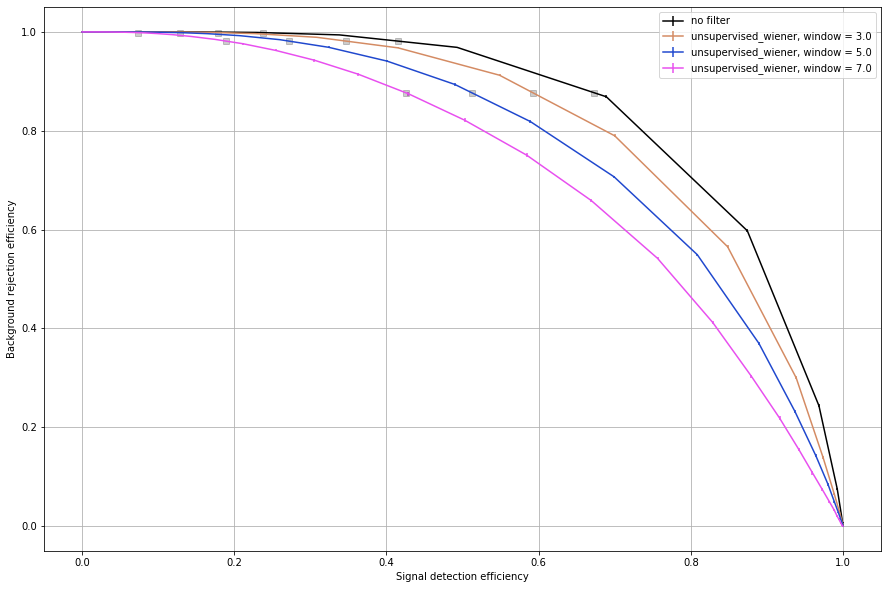

In [30]:
np.random.seed(5)
thr_points = [0.5,1,1.5]
new_thr_values = []
objects = roc_params_build(mean_sg,mean_bg,filters)
base_background_values = objects[filters[0]][1][1](thr_points)
base_signal_values = []
fig,ax = plt.subplots(1,1, figsize=(15,10))
flag = 0
for i,f in list(enumerate(filters)):
    base_signal_values.append(objects[f][2][1](base_background_values))
    if (sum(df_filt[df_filt['w_size'] == 1.0]['ftype'] == filters[i]) != 0):
        color = 'black'
        label = 'no filter'
        flag+=1
        if flag<=1:
            ax.errorbar(mean_sg[:,i],
                        mean_bg[:,i],
                        2*std_bg[:,i],
                        linestyle = '-',
                        label = label,
                        color = color) 
            
    else:
        color = '#%06X' % np.random.randint(0, 0xFFFFFF)
        label = f
        ax.errorbar(mean_sg[:,i],
                    mean_bg[:,i],
                    2*std_bg[:,i],
                    linestyle = '-',
                    label = label,
                    color = color) 
base_signal_values = np.array(base_signal_values).ravel()   
base_background_values = np.tile(base_background_values,len(filters))
ax.plot(base_signal_values,base_background_values,'sk',alpha = 0.2)
plt.legend()
plt.grid()
plt.xlabel('Signal detection efficiency')
plt.ylabel('Background rejection efficiency')